In [1]:
import numpy as np
import math
import cmath
import gudhi as gd
import pandas  as pd
import matplotlib.pyplot as plt
import timeit
import scipy 
import joypy

In [4]:
#Pertinent constants

#Hubble Constant 70 (km/s)/Mpc = 3.0855895*10^19 s^-1
H_0 = 3.0855895*10**19
#H_0=1.0

#Cosmological Density (lets be optimistic and say the universe will last forever)
Om_0 = 1.0

#speed of light (m/s)
c =  299792458 
#c=1.0


In [5]:
#input redshift of a plane output Friedmann angular diameter distance as viewed by an observer at redshift 0
def FADD1(z):
    d1 = (c/H_0)*abs((2/(Om_0**2*(1+z)**2))*(Om_0*z-(2-Om_0)*(np.sqrt(1+Om_0*z)-1)))
    return d1;

In [6]:
def R1(z):
    r1=(Om_0*z-Om_0+2)/(1+z)**2
    return r1

In [7]:
def R2(z):
    r2=np.sqrt(Om_0*z+1)/(1+z)**2
    return r2

In [8]:
#input redshift of two planes output Friedmann angular diameter distance of plane 2 as viewed by an observer at plane 1
def FADD2(z1, z2):
    d12 = (c/H_0)*abs((2*(1+z1)/Om_0**2)*(R1(z2)*R2(z1)-R1(z1)*R2(z2)))
    return d12;

In [9]:
def Theta(zi,zj):
    theta_ij=(1+zi)*(FADD1(zi)*FADD1(zj))/(c*FADD2(zi,zj))
    return theta_ij

In [10]:
def Beta(zi,zj,zS):
    beta_ij=(FADD2(zi,zj)*FADD1(zS))/(FADD1(zj)*FADD2(zi,zS))
    return beta_ij

In [2]:
def PointLensPotential(X, Y, yy, xi, mass):
    #Quadratic part
    Q=((X-yy[0])**2+(Y-yy[1])**2)/2
    #Gravitational Part
    G=0
    for i in range(len(xi)):
        G=G+mass[i]*np.log(np.sqrt((X-xi[i][0])**2+(Y-xi[i][1])**2))
    return Q-G

In [3]:
def LensingMap1(x, xix, xiy, m, yy):
    T1 = np.sum(np.multiply(np.divide(m,np.add(np.square(np.subtract(x[0],xix)),np.square(np.subtract(x[1],xiy)))),np.subtract(x[0],xix)),axis=0)
    T2 = np.sum(np.multiply(np.divide(m,np.add(np.square(np.subtract(x[0],xix)),np.square(np.subtract(x[1],xiy)))),np.subtract(x[1],xiy)),axis=0)
    return [x[0]-yy[0]- T1,
            x[1]-yy[1]- T2]

In [4]:
def LensingMap(x, xix, xiy, m, yy):
    #lensing map components(x_i - yy_i - sum(m_i(x_i-xi_i)/|x-xi|^2))
    SS = np.add(np.square(np.subtract(x[0],xix)),np.square(np.subtract(x[1],xiy)))
    SM = np.divide(m,SS)
    SPx = np.multiply(SM,np.subtract(x[0],xix))
    SPy = np.multiply(SM,np.subtract(x[1],xiy))
    T1 = np.sum(SPx,axis=0)
    T2 = np.sum(SPy,axis=0)
    return [x[0]-yy[0]- T1,
            x[1]-yy[1]- T2]

In [14]:
#arg 1-4 grid elements for evaluation; arg 5,8 mass positions; arg 6, 9 masses; arg 7, 10 lens plane redshifts;
#arg 11 source position; arg 12 source plane redshift 

#may consider meshgrid in the future; for now? for loops!


def PointLensPotential2(X1, Y1, X2, Y2, xx1, m1, z1, xx2, m2, z2, yy, z3):
    #operational constants 
    i11=len(X1)
    i12=len(Y1)
    i21=len(X2)
    i22=len(Y2)
    g1=len(xx1)
    g2=len(xx2)
    #this where the data go
    z=np.zeros((i11,i12,i21,i22),dtype=float)
    
    #Scaling Constants
    theta1=Theta(z1,z2)
    theta2=Theta(z2,z3)
    Beta1=Beta(z1,z2,z3)
    Beta2=Beta(z2,z3,z3)
    
    for j11 in range(i11):
        for j12 in range(i12):
            for j21 in range(i21):
                for j22 in range(i22):
                    Q1=.5*((X1[j11]-X2[j21])**2+(Y1[j12]-Y2[j22])**2)
                    G1=0
                    for i in range(g1):
                        G1=G1+m1[i]*np.log(np.sqrt((X1[j11]-xx1[i,0])**2+(Y1[j12]-xx1[i,1])**2))
                    Q2=.5*((X2[j21]-yy[0])**2+(Y2[j22]-yy[1])**2)
                    G2=0
                    for i in range(g2):
                        G2=G2+m2[i]*np.log(np.sqrt((X2[j11]-xx2[i,0])**2+(Y2[j12]-xx2[i,1])**2))                    
                    z[j11,j12,j21,j22]=theta1*(Q1 - Beta1*G1)+theta2*(Q2 - Beta2*G2) 
    return z


In [24]:
#2 plane Rhie type example
start_time = timeit.default_timer()
#plane1
#redshift
z1=.1;
#number of mass points total
g1=3
#mass of mass points (on circle)
m1=(2/g1)*np.ones(g1)
#radius of the circle
r1=1.0
#the tiny center mass
m1[g1-1]=.2*m1[g1-1]
#location of mass points
xx1=np.zeros((g1,2),float)
theta = math.pi * 2 / (g1-1) 
for i in range(g1-1): 
    xx1[i][0]=r1*math.cos(i*theta)
    xx1[i][1]=r1*math.sin(i*theta)
xx1[g1-1]=[0.0,0.0]

#plane2
#redshift
z2=.2;
#number of mass points (on circle)
g2=3
#mass of mass points (on circle)
m2=(2/g2)*np.ones(g2)
#radius of the circle
r2=0.1
#the tiny center mass
m2[g2-1]=.2*m2[g2-1]
#location of mass points
xx2=np.zeros((g2,2),float)
theta = math.pi * 2 / (g2-1) 
for i in range(g2-1): 
    xx2[i][0]=r2*math.cos(i*theta)
    xx2[i][1]=r2*math.sin(i*theta)
xx2[g2-1]=[0.0,0.0]

#location of source
yy=[0.0,0.0]
#redshift of source
z3=.3

X1=np.linspace(-2,2,100)
Y1=np.linspace(-2,2,100)
#X1,Y1 = np.meshgrid(x1,y1)
X2=np.linspace(-.2,.2,100)
Y2=np.linspace(-.2,.2,100)
#X2,Y2 = np.meshgrid(x2,y2)

z=PointLensPotential2(X1,Y1, X2, Y2, xx1, m1, z1, xx2, m2, z2, yy, z3)
elapsed = timeit.default_timer() - start_time
print(elapsed)
z

3777.9149784129113


array([[[[5.01357416e-20, 5.01673751e-20, 5.01994308e-20, ...,
          5.51699153e-20, 5.52425015e-20, 5.53155098e-20],
         [5.01673751e-20, 5.01990086e-20, 5.02310642e-20, ...,
          5.52015488e-20, 5.52741349e-20, 5.53471433e-20],
         [5.01994308e-20, 5.02310642e-20, 5.02631199e-20, ...,
          5.52336045e-20, 5.53061906e-20, 5.53791989e-20],
         ...,
         [5.51699153e-20, 5.52015488e-20, 5.52336045e-20, ...,
          6.02040890e-20, 6.02766752e-20, 6.03496835e-20],
         [5.52425015e-20, 5.52741349e-20, 5.53061906e-20, ...,
          6.02766752e-20, 6.03492613e-20, 6.04222696e-20],
         [5.53155098e-20, 5.53471433e-20, 5.53791989e-20, ...,
          6.03496835e-20, 6.04222696e-20, 6.04952779e-20]],

        [[5.00656112e-20, 5.00961877e-20, 5.01271863e-20, ...,
          5.49972571e-20, 5.50687862e-20, 5.51407376e-20],
         [5.00972447e-20, 5.01278211e-20, 5.01588198e-20, ...,
          5.50288906e-20, 5.51004197e-20, 5.51723710e-20],
        

In [ ]:
start_time = timeit.default_timer()
bincount=100
bins = np.linspace(z.min(),z.max(),bincount)
inds = np.digitize(z,bins)

file = open("starpersR2.txt","w") 
file.write(str(len(z.shape))+"\n")
file.write(str(z.shape[0])+"\n") 
file.write(str(z.shape[1])+"\n")
file.write(str(z.shape[2])+"\n") 
file.write(str(z.shape[3])+"\n")

for i in range(z.shape[0]):
    for j in range(z.shape[1]):
        for k in range(z.shape[2]):
            for l in range(z.shape[3]):
                if  inds[i][j][k][l]==bincount:
                    file.write("inf"+"\n")
                else:
                    file.write(str(inds[i][j][k][l])+"\n")

file.close()

cc = gd.CubicalComplex(perseus_file="starpersR2.txt")
pers_cc = cc.persistence()      
pers_cc_0 = cc.persistence_intervals_in_dimension(0)
pers_cc_1 = cc.persistence_intervals_in_dimension(1)
pers_cc_2 = cc.persistence_intervals_in_dimension(2)
pers_cc_3 = cc.persistence_intervals_in_dimension(3)

elapsed = timeit.default_timer() - start_time
print(elapsed)


In [23]:
pers_cc_3

array([], dtype=float64)

In [ ]:
gd.plot_persistence_diagram(pers_cc);

In [ ]:
print(len(pers_cc_0),len(pers_cc_1),len(pers_cc_2),len(pers_cc_3))

125 2.878781994914195e-12


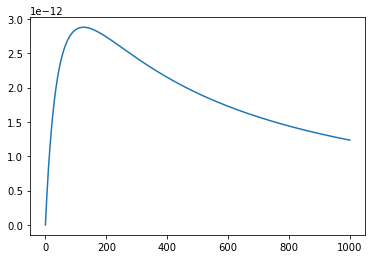

In [15]:
z=np.arange(0,10,.01)
test=FADD1(z)
plt.plot(test)
print(test.argmax(),test.max())

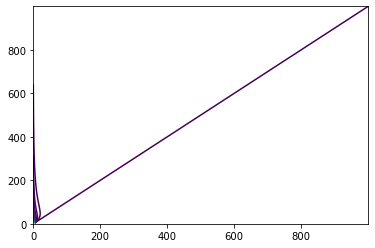

In [163]:
z1lb = 0.0
z1ub=100
z1step = 1
z2lb=0.0
z2ub=100
z2step= 1

z1=np.arange(z1lb, z1ub,z1step)
z2=np.arange(z2lb, z2ub,z2step)
Z1,Z2=np.meshgrid(z1,z2)

z=FADD2(Z1,Z2)

for i in range(int(z1ub/z1step)):
    for j in range(int(z2ub/z2step)):
        if j>i:
            z[i,j]=0

mid = z.min()+1*(z.max()-z.min())
grid = np.linspace(z.min(),mid,100)
plt.contour(z1,z2,z,grid)



In [155]:
int(z1ub*z1step)

1

In [153]:
z.shape

(100, 100)

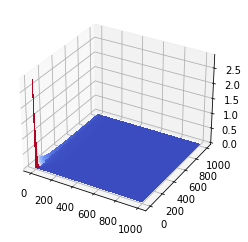

In [164]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})


# Plot the surface.
surf = ax.plot_surface(Z1, Z2, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, )
ax.view_init(30,300)

In [60]:
z1= .5
z2= .99
z3= 1

theta12=Theta(z1,z2)
theta13=Theta(z1,z3)
theta23=Theta(z2,z3)

beta12=Beta(z1,z2,z3)
beta13=Beta(z1,z3,z3)
beta23=Beta(z2,z3,z3)

a=1/theta13
b=1/theta12+1/theta23
alpha=(1+z1)/(1+z2)
d = FADD1(z3)*FADD2(z1,z2)+alpha*FADD1(z1)*FADD2(z2,z3)
e = FADD1(z2)*FADD2(z1,z3)
g=FADD2(z2,z1)
h=((1+z2)/(1+z1))*FADD2(z1,z2)
#print(a,b)
#print(d,e)
#print(g,h)

#print(theta13, theta12, theta23)

print(FADD1(z1),FADD1(z2),FADD1(z3))
print(FADD2(z1,z2), FADD2(z1,z3), FADD2(z2,z3))
print(FADD2(z1,z2)*FADD1(z3), FADD2(z1,z3)*FADD1(z2))
print(beta12,beta13,beta23)

2.377198524737055e-12 2.8426914228497766e-12 2.845718071040128e-12
1.0508332383746114e-12 1.062819177487338e-12 1.724010530460032e-14
2.99037513609225e-24 3.02126695988351e-24
0.989775208810925 1.0 1.0


(0.0, 2.0)

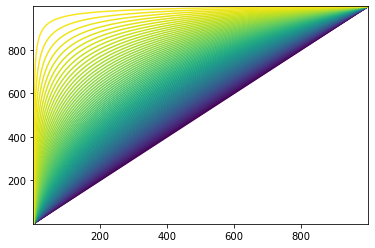

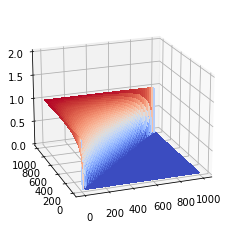

In [219]:

z1lb = 0.01
z1ub=1000
z1step = .1
z2lb=0.01
z2ub=1000
z2step= .1

z3=1000.1


z1=np.arange(z1lb, z1ub,z1step)
z2=np.arange(z2lb, z2ub,z2step)
Z1,Z2=np.meshgrid(z1,z2)

beta12=Beta(Z1,Z2,z3)

for i in range(int(z1ub/z1step)):
    for j in range(int(z2ub/z2step)):
        if j>i:
            beta12[i,j]=0

plt.contour(Z1,Z2,beta12,100)


fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface.
surf = ax.plot_surface(Z1, Z2, beta12, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, )
ax.view_init(20,250)
ax.set_zlim3d(0,2)

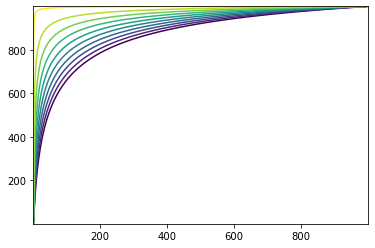

In [224]:
grid = np.linspace(.9,.999,10)
plt.contour(Z1,Z2,beta12,grid)

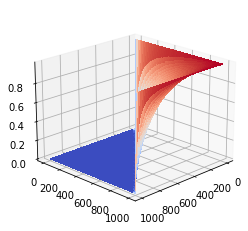

In [221]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface.
surf = ax.plot_surface(Z1, Z2, beta12, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, )
ax.view_init(20,45)


In [213]:

ind = np.unravel_index(np.argmax(beta12, axis=None), beta12.shape)
ind
beta12.shape
ind

(101, 100)

In [217]:
beta12.max()
Beta(101.1,100)

TypeError: Beta() missing 1 required positional argument: 'zS'

In [236]:
z0= .001
z1= 1
z2= 500
z3= 999
z4= 999.99
z5= 1000

beta01=Beta(z0,z1,z5)
beta02=Beta(z0,z2,z5)
beta03=Beta(z0,z3,z5)
beta04=Beta(z0,z4,z5)
beta12=Beta(z1,z2,z5)
beta13=Beta(z1,z3,z5)
beta14=Beta(z1,z4,z5)
beta23=Beta(z2,z3,z5)
beta24=Beta(z2,z4,z5)
beta34=Beta(z3,z4,z5)


print('beta01 =',beta01)
print('beta02 =',beta02)
print('beta03 =',beta03)
print('beta04 =',beta04)
print('beta12 =',beta12)
print('beta13 =',beta13)
print('beta14 =',beta14)
print('beta23 =',beta23)
print('beta24 =',beta24)
print('beta34 =',beta34)

beta01 = 0.9988094906355348
beta02 = 0.999992937912566
beta03 = 0.9999999915779703
beta04 = 0.9999999999158437
beta12 = 0.9940680118574435
beta13 = 0.9999929256921333
beta14 = 0.9999999293105425
beta23 = 0.9988074305448931
beta24 = 0.999988083344725
beta34 = 0.9900075796637654


In [35]:
df_countBySolver = pd.DataFrame()
#Count solutions as per the lensing map images numerical solutions
N = len(df4)
df = pd.DataFrame()
df['g+1'] = [g+1]
df['N'] = [N]
df_countBySolver = df_countBySolver.append(df,ignore_index=True)

In [52]:
df_Pers = pd.DataFrame()
df_MassLocs = pd.DataFrame()
df_count=pd.DataFrame()
for i in range(len(xi)):
    df['g']=[g]
    df['xi']=[xi[i]]
    df['xix']=[xi[i,0]]
    df['xiy']=[xi[i,1]]
    df_MassLocs=df_MassLocs.append(df,ignore_index=True)


win=np.sqrt(g+1)

x=np.linspace(-1*win,win,4000)
y=np.linspace(-1*win,win,4000)
X,Y = np.meshgrid(x,y)

z=PointLensPotential(X,Y,yy,xi,mass)

elapsed = timeit.default_timer() - start_time            
print(elapsed)

bincount=2000
bins = np.linspace(z.min(),z.max(),bincount)
inds = np.digitize(z,bins)

file = open("Rhie1persu.txt","w") 
file.write(str(len(z.shape))+"\n")
file.write(str(z.shape[0])+"\n")
file.write(str(z.shape[1])+"\n")

for i in range(z.shape[0]):
    for j in range(z.shape[1]):
        if  inds[i][j]==bincount:
            file.write("inf"+"\n")
        else:
            file.write(str(inds[i][j])+"\n")
file.close()

cc = gd.CubicalComplex(perseus_file="Rhie1persu.txt")
pers_cc = cc.persistence()      
pers_cc_0 = cc.persistence_intervals_in_dimension(0)
pers_cc_1 = cc.persistence_intervals_in_dimension(1)

for i in range(pers_cc_0.shape[0]):
    df=pd.DataFrame()
    df['g']=[g]
    df['i']=0
    df['b']=pers_cc_0[i][0]
    df['d']=pers_cc_0[i][1]
    df_Pers=df_Pers.append(df)
for i in range(pers_cc_1.shape[0]):
    df=pd.DataFrame()
    df['g']=[g]
    df['i']=1
    df['b']=pers_cc_1[i][0]
    df['d']=pers_cc_1[i][1]
    df_Pers=df_Pers.append(df)

H_0 = len(pers_cc_0)
H_1 = len(pers_cc_1)
N_0 = H_0
N_1 = H_0 - 1 + H_1
N = N_0 + N_1
df = pd.DataFrame()
df['g'] = [g]
df['N'] = [N]
df['N_0'] = [N_0]
df['N_1'] = [N_1]
df['|H_0|'] = [H_0]
df['|H_1|'] = [H_1]
df['2N0+g-1']= [2 * N_0 + g -1]
df['2N1-g+1']= [2 * N_1 - g +1]
df_count = df_count.append(df)




230458.43001991883
230482.50165077578
230574.70304215187


,g,N,N_0,N_1,|H_0|,|H_1|,2N0+g-1,2N1-g+1
0,4,20,8,12,8,5,19,21


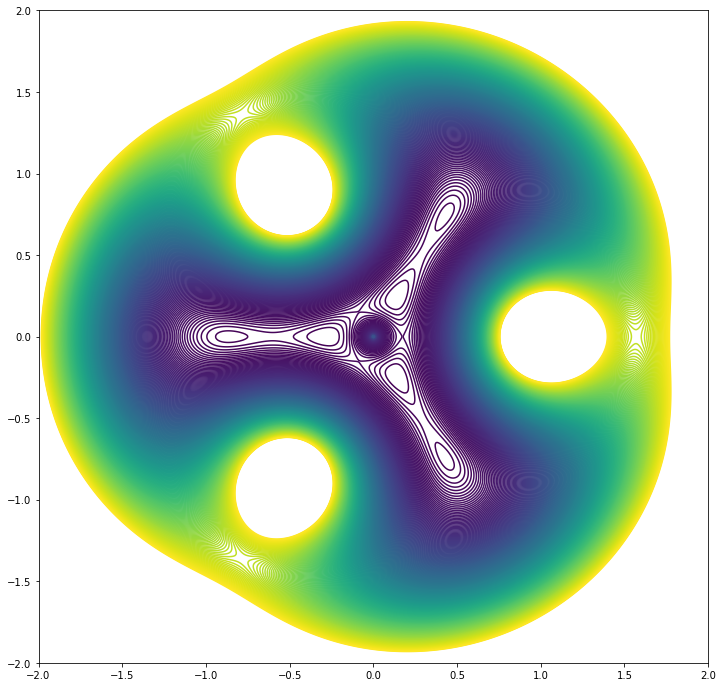

In [8]:
##### Rhie type (Functionalized and perturbed)

#Mass perturbation factor
#em=.007
em=0

#Position perturbation factor
#ep=.007
ep=0

#Source perturbation factor
#es=.005
#es=0

#location of source
yy=[0.0,0.0]

#number of mass points (on circle)
g=3
#mass of mass points (on circle)

bm= .6

#a=20
#bm=2*a/(3*a+1)
mass=bm*np.ones(g+1)

#the tiny center mass
#shrink=.09
#mass[g] = shrink*mass[g]
sm = .04
#sm= (1/a)*bm
mass[g] = sm

#for g = 3, a max occurs at bm=2.35/(g+1), shrink = .09, 
#low pair (bm,sm)=(.575,.0499)
#high pair ()
#high low (2.5,.002) <- M2 and S3 tighten around central asymptote (indefinitely?)
#low high (.549,.0675) <- M1 S2 and M2 merge. Can we truly normalize masses to sum to 1?? 
#simple (.6,.04)
#"normalize" to sum to 2 (summing to 1 has issues. see #low high) (40/61,4/122)

#purturb masses
mass = mass + em*np.random.rand(g+1)

#location of mass points
xi=np.zeros((g+1,2),float)

theta = math.pi * 2 / g

for i in range(g): 
    xi[i][0]=math.cos(i*theta)
    xi[i][1]=math.sin(i*theta)
xi[g]=[0.0,0.0]

#perturb locations
xi = xi + ep*np.random.rand(g+1,2)

win=1.5*np.sqrt(g+1)
x=np.linspace(-1*win,win,1000)
y=np.linspace(-1*win,win,1000)
#x=np.linspace(-.60,-.55,1000)
#y=np.linspace(-.025,.025,1000)


X,Y = np.meshgrid(x,y)

z=PointLensPotential(X,Y,yy,xi,mass)

grid = np.linspace(z.min(),.1*z.max(),250)
fig, ax = plt.subplots()
ax.contour(X,Y,z,grid)

plt.axis([-2,2,-2,2])
fig.set_size_inches(12, 12)



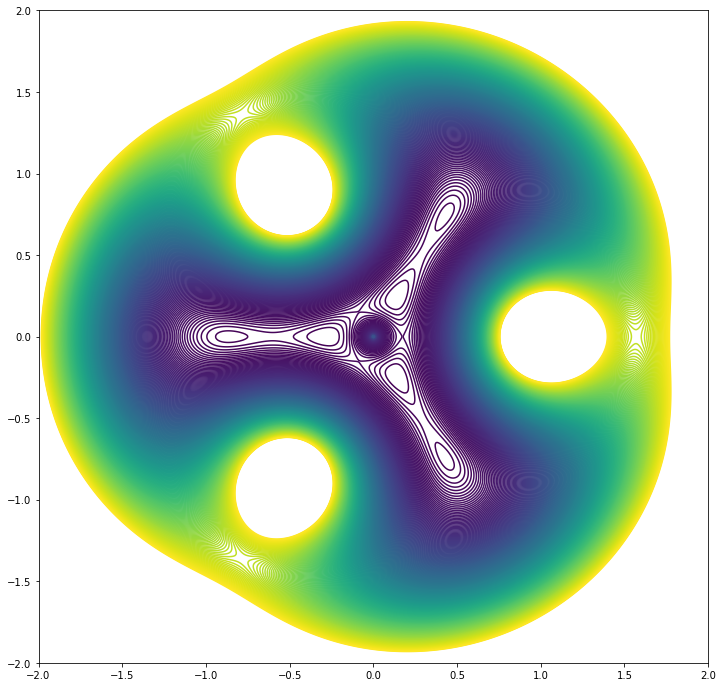

In [16]:


#location of source
yy=[0.0,0.0]

#number of mass points (on circle)
g=3

#mass of mass points (on circle)
bm= .6
mass=bm*np.ones(g+1)

#the tiny center mass
sm = .04
mass[g] = sm

#location of mass points
xi=np.zeros((g+1,2),float)

theta = math.pi * 2 / g

for i in range(g): 
    xi[i][0]=math.cos(i*theta)
    xi[i][1]=math.sin(i*theta)
xi[g]=[0.0,0.0]

win=1.5*np.sqrt(g+1)
x=np.linspace(-1*win,win,1000)
y=np.linspace(-1*win,win,1000)
X,Y = np.meshgrid(x,y)
z=PointLensPotential(X,Y,yy,xi,mass)

grid = np.linspace(z.min(),.1*z.max(),250)
fig, ax = plt.subplots()
ax.contour(X,Y,z,grid)

plt.axis([-2,2,-2,2])
fig.set_size_inches(12, 12)



In [9]:
start_time = timeit.default_timer()

xix=xi[:,0]
xiy=xi[:,1]

df_RhieSolns=pd.DataFrame()

x1gridcount = 100
y1gridcount = 100
x1gridstart = -1*win
x1gridstop = win
y1gridstart = -1*win
y1gridstop = win
x=np.linspace(x1gridstart,x1gridstop, x1gridcount)
y=np.linspace(y1gridstart,y1gridstop, y1gridcount)



#Evaluate numerical solutions to lensing map over initial conditions with fsolve.
df1=pd.DataFrame()
for i1 in range(len(x)):
    for j1 in range(len(y)):
        image = scipy.optimize.fsolve(LensingMap1,[x[i1],y[j1]],args=(xix,xiy,mass,yy))
        df=pd.DataFrame()
        df['g']=[g]
        df['image']=[image]
        df['imagex']=[image[0]]
        df['imagey']=[image[1]]
        df['xind']=[i1]
        df['yind']=[j1]
        df1=df1.append(df,ignore_index=True)


#Remove solutions which are too close to the singularities 
#(fsolve returns these values if an initial condition is a mass location.)
#(Probably an unnecessary step left over from  non-stochastic experiments)     
df2=df1
recloc = []
for i in range(len(df2)):
    for j in range(len(xi)):
        if np.allclose([df2['imagex'].values[i],df2['imagex'].values[i]],xi[j]):
            recloc = np.append(recloc,i)
if len(recloc)>0:
    recloc = recloc.astype(int)
    df2=df2.drop(df2['image'].index[recloc])
    df2.index=range(len(df2))

#group solutions close to one another together 
#(sorts individual fsolve solutions into equiv classes)
df3=df2
i=0
while i<len(df3):
    recloc=[]
    for j in range(i+1,len(df3)):
        if np.allclose(df3['image'].values[i],df3['image'].values[j]):
            recloc = np.append(recloc,j)
    if len(recloc)>0:
        recloc=recloc.astype(int)
        df3=df3.drop(df3.index[recloc])
        df3.index=range(len(df3))
    i=i+1

#kill spurious nonsolutions generated by fsolve 
#(mysterious but consistent error where fsolve returns non solution)
df4=df3
recloc = []
for i in range(len(df4)):
    if np.logical_not(np.allclose([0.0,0.0],LensingMap1(df4['image'][i],xix,xiy,mass,yy))):
            recloc = np.append(recloc,i)
if len(recloc)>0:
    recloc = recloc.astype(int)
    df4=df4.drop(df4['image'].index[recloc])
    df4.index=range(len(df4))

df_RhieSolns = df_RhieSolns.append(df4,ignore_index=True)
elapsed = timeit.default_timer() - start_time            
print(elapsed)


/home/bill/.conda/envs/lensing/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


40.10749548199237


In [10]:
df_RhieSolns

,g,image,imagex,imagey,xind,yind
0,3,"[-0.7852419624185722, 1.3600789751441429]",-0.785242,1.360079e+00,0,0
1,3,"[-0.8608434976523199, 3.772062086164803e-16]",-0.860843,3.772062e-16,0,1
2,3,"[-0.7852419624086022, -1.3600789751493771]",-0.785242,-1.360079e+00,0,14
3,3,"[0.4304217488261735, 0.7455123376495899]",0.430422,7.455123e-01,10,0
4,3,"[0.4304217488261734, -0.7455123376495902]",0.430422,-7.455123e-01,10,99
5,3,"[1.5704839248372078, -5.948827513704277e-12]",1.570484,-5.948828e-12,23,1
6,3,"[0.3011466305110262, -0.5216012645732692]",0.301147,-5.216013e-01,23,4
7,3,"[0.30114663051102725, 0.5216012645732706]",0.301147,5.216013e-01,23,95
8,3,"[-0.28171945024798023, 2.65670845508619e-14]",-0.281719,2.656708e-14,33,44
9,3,"[-0.6022932610220563, 2.9407361186500867e-15]",-0.602293,2.940736e-15,34,45


In [11]:
start_time = timeit.default_timer()

xix=xi[:,0]
xiy=xi[:,1]

df_RhieSolns=pd.DataFrame()

x1gridcount = 100
y1gridcount = 100
x1gridstart = -1*win
x1gridstop = win
y1gridstart = -1*win
y1gridstop = win
x=np.linspace(x1gridstart,x1gridstop, x1gridcount)
y=np.linspace(y1gridstart,y1gridstop, y1gridcount)



#Evaluate numerical solutions to lensing map over initial conditions with fsolve.
df1=pd.DataFrame()
for i1 in range(len(x)):
    for j1 in range(len(y)):
        image = scipy.optimize.fsolve(LensingMap,[x[i1],y[j1]],args=(xix,xiy,mass,yy))
        df=pd.DataFrame()
        df['g']=[g]
        df['image']=[image]
        df['imagex']=[image[0]]
        df['imagey']=[image[1]]
        df['xind']=[i1]
        df['yind']=[j1]
        df1=df1.append(df,ignore_index=True)


#Remove solutions which are too close to the singularities 
#(fsolve returns these values if an initial condition is a mass location.)
#(Probably an unnecessary step left over from  non-stochastic experiments)     
df2=df1
recloc = []
for i in range(len(df2)):
    for j in range(len(xi)):
        if np.allclose([df2['imagex'].values[i],df2['imagex'].values[i]],xi[j]):
            recloc = np.append(recloc,i)
if len(recloc)>0:
    recloc = recloc.astype(int)
    df2=df2.drop(df2['image'].index[recloc])
    df2.index=range(len(df2))

#group solutions close to one another together 
#(sorts individual fsolve solutions into equiv classes)
df3=df2
i=0
while i<len(df3):
    recloc=[]
    for j in range(i+1,len(df3)):
        if np.allclose(df3['image'].values[i],df3['image'].values[j]):
            recloc = np.append(recloc,j)
    if len(recloc)>0:
        recloc=recloc.astype(int)
        df3=df3.drop(df3.index[recloc])
        df3.index=range(len(df3))
    i=i+1

#kill spurious nonsolutions generated by fsolve 
#(mysterious but consistent error where fsolve returns non solution)
df4=df3
recloc = []
for i in range(len(df4)):
    if np.logical_not(np.allclose([0.0,0.0],LensingMap1(df4['image'][i],xix,xiy,mass,yy))):
            recloc = np.append(recloc,i)
if len(recloc)>0:
    recloc = recloc.astype(int)
    df4=df4.drop(df4['image'].index[recloc])
    df4.index=range(len(df4))

df_RhieSolns = df_RhieSolns.append(df4,ignore_index=True)
elapsed = timeit.default_timer() - start_time            
print(elapsed)


/home/bill/.conda/envs/lensing/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


40.59310428798199


In [12]:
df_RhieSolns

,g,image,imagex,imagey,xind,yind
0,3,"[-0.7852419624185722, 1.3600789751441429]",-0.785242,1.360079e+00,0,0
1,3,"[-0.8608434976523199, 3.772062086164803e-16]",-0.860843,3.772062e-16,0,1
2,3,"[-0.7852419624086022, -1.3600789751493771]",-0.785242,-1.360079e+00,0,14
3,3,"[0.4304217488261735, 0.7455123376495899]",0.430422,7.455123e-01,10,0
4,3,"[0.4304217488261734, -0.7455123376495902]",0.430422,-7.455123e-01,10,99
5,3,"[1.5704839248372078, -5.948827513704277e-12]",1.570484,-5.948828e-12,23,1
6,3,"[0.3011466305110262, -0.5216012645732692]",0.301147,-5.216013e-01,23,4
7,3,"[0.30114663051102725, 0.5216012645732706]",0.301147,5.216013e-01,23,95
8,3,"[-0.28171945024798023, 2.65670845508619e-14]",-0.281719,2.656708e-14,33,44
9,3,"[-0.6022932610220563, 2.9407361186500867e-15]",-0.602293,2.940736e-15,34,45


In [439]:
absz = np.power(np.square(zx)+np.square(zy),.5)
absz.max()

1.570483924837218

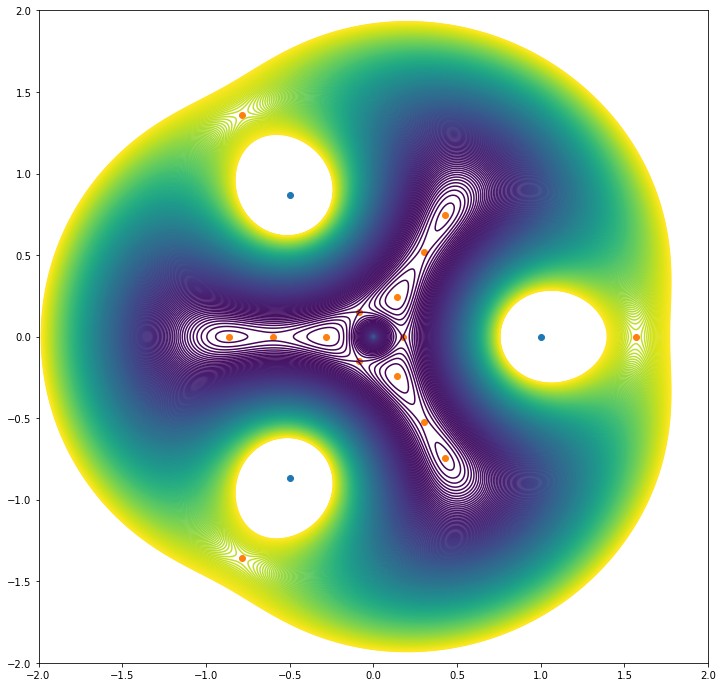

In [19]:
zx = df_RhieSolns['imagex'].values
zy = df_RhieSolns['imagey'].values

grid1 = np.linspace(z.min(),.1*z.max(),250)

fig, ax = plt.subplots()
ax.contour(X,Y,z,grid1)
ax.scatter(xix,xiy)
ax.scatter(zx,zy)

plt.axis([-2,2,-2,2])
fig.set_size_inches(12, 12)

In [20]:
#Loop with scaled images as sources

start_time = timeit.default_timer()

df_2RhieSolns=pd.DataFrame()

srcs=zx.size
for s in range(srcs):
    yy = [1/200*zx[s],1/200*zy[s]]
    
    x1gridcount = 100
    y1gridcount = 100
    x1gridstart = -1*win
    x1gridstop = win
    y1gridstart = -1*win
    y1gridstop = win
    x=np.linspace(x1gridstart,x1gridstop, x1gridcount)
    y=np.linspace(y1gridstart,y1gridstop, y1gridcount)



    #Evaluate numerical solutions to lensing map over initial conditions with fsolve.
    df1=pd.DataFrame()
    for i1 in range(len(x)):
        for j1 in range(len(y)):
            image = scipy.optimize.fsolve(LensingMap1,[x[i1],y[j1]],args=(xix,xiy,mass,yy))
            df=pd.DataFrame()
            df['g']=[g]
            df['src']=[s]
            df['image']=[image]
            df['imagex']=[image[0]]
            df['imagey']=[image[1]]
            df['xind']=[i1]
            df['yind']=[j1]
            df1=df1.append(df,ignore_index=True)


    #Remove solutions which are too close to the singularities 
    #(fsolve returns these values if an initial condition is a mass location.)
    #(Probably an unnecessary step left over from  non-stochastic experiments)     
    df2=df1
    recloc = []
    for i in range(len(df2)):
        for j in range(len(xi)):
            if np.allclose([df2['imagex'].values[i],df2['imagex'].values[i]],xi[j]):
                recloc = np.append(recloc,i)
    if len(recloc)>0:
        recloc = recloc.astype(int)
        df2=df2.drop(df2['image'].index[recloc])
        df2.index=range(len(df2))

    #group solutions close to one another together 
    #(sorts individual fsolve solutions into equiv classes)
    df3=df2
    i=0
    while i<len(df3):
        recloc=[]
        for j in range(i+1,len(df3)):
            if np.allclose(df3['image'].values[i],df3['image'].values[j]):
                recloc = np.append(recloc,j)
        if len(recloc)>0:
            recloc=recloc.astype(int)
            df3=df3.drop(df3.index[recloc])
            df3.index=range(len(df3))
        i=i+1

    #kill spurious nonsolutions generated by fsolve 
    #(mysterious but consistent error where fsolve returns non solution)
    df4=df3
    recloc = []
    for i in range(len(df4)):
        if np.logical_not(np.allclose([0.0,0.0],LensingMap1(df4['image'][i],xix,xiy,mass,yy))):
                recloc = np.append(recloc,i)
    if len(recloc)>0:
        recloc = recloc.astype(int)
        df4=df4.drop(df4['image'].index[recloc])
        df4.index=range(len(df4))

    df_2RhieSolns = df_2RhieSolns.append(df4,ignore_index=True)
    elapsed = timeit.default_timer() - start_time            
    print(elapsed)
    print(s)



/home/bill/.conda/envs/lensing/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


47.15638336201664
0
92.36131812806707
1
138.3388008349575
2
183.91821366897784
3
230.5692543090554
4
276.89712089300156
5
324.1260780959856
6
371.28958566498477
7
417.9945479379967
8
464.00877477799077
9
506.76372505002655
10
549.5745931600686
11
596.9954514440615
12
640.9487814960303
13
684.8634961530333
14


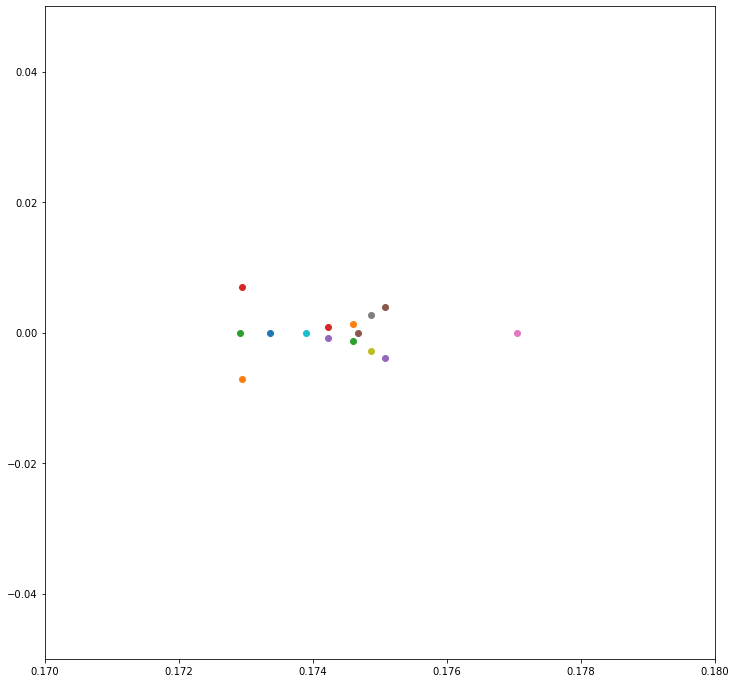

In [26]:

fig, ax = plt.subplots()
ax.scatter(xix,xiy)
for i in range(srcs):
    zzx = df_2RhieSolns[df_2RhieSolns['src']==i]['imagex'].values
    zzy = df_2RhieSolns[df_2RhieSolns['src']==i]['imagey'].values
    ax.scatter(zzx,zzy)
    
plt.axis([.17,.18,-.05,.05])
fig.set_size_inches(12, 12)

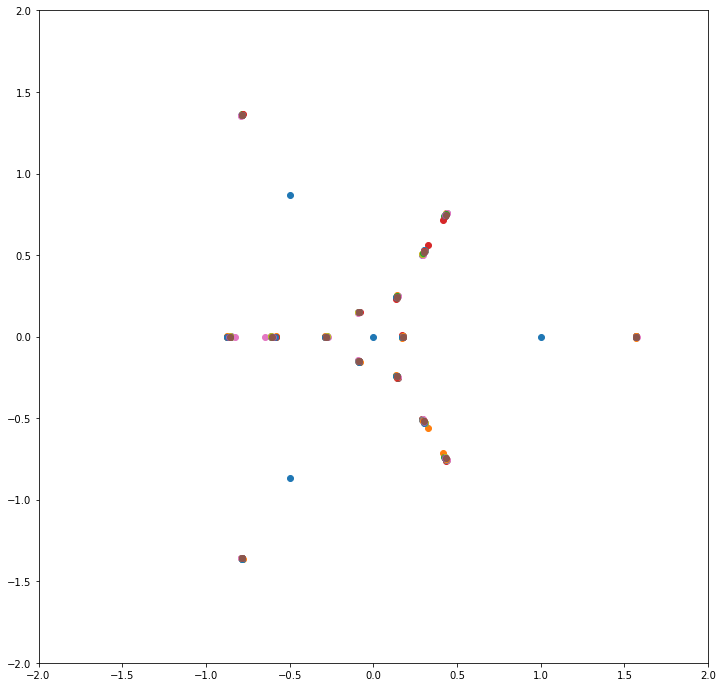

In [24]:

fig, ax = plt.subplots()
ax.scatter(xix,xiy)
for i in range(srcs):
    zzx = df_2RhieSolns[df_2RhieSolns['src']==i]['imagex'].values
    zzy = df_2RhieSolns[df_2RhieSolns['src']==i]['imagey'].values
    ax.scatter(zzx,zzy)
    
plt.axis([-2,2,-2,2])
fig.set_size_inches(12, 12)

In [462]:
#Loop with scaled images as sources

start_time = timeit.default_timer()

df_2RhieSolns=pd.DataFrame()

srcs=zx.size
for s in range(srcs):
    yy = [1/150*zx[s],1/150*zy[s]]
    
    x1gridcount = 100
    y1gridcount = 100
    x1gridstart = -1*win
    x1gridstop = win
    y1gridstart = -1*win
    y1gridstop = win
    x=np.linspace(x1gridstart,x1gridstop, x1gridcount)
    y=np.linspace(y1gridstart,y1gridstop, y1gridcount)



    #Evaluate numerical solutions to lensing map over initial conditions with fsolve.
    df1=pd.DataFrame()
    for i1 in range(len(x)):
        for j1 in range(len(y)):
            image = scipy.optimize.fsolve(LensingMap1,[x[i1],y[j1]],args=(xix,xiy,mass,yy))
            df=pd.DataFrame()
            df['g']=[g]
            df['src']=[s]
            df['image']=[image]
            df['imagex']=[image[0]]
            df['imagey']=[image[1]]
            df['xind']=[i1]
            df['yind']=[j1]
            df1=df1.append(df,ignore_index=True)


    #Remove solutions which are too close to the singularities 
    #(fsolve returns these values if an initial condition is a mass location.)
    #(Probably an unnecessary step left over from  non-stochastic experiments)     
    df2=df1
    recloc = []
    for i in range(len(df2)):
        for j in range(len(xi)):
            if np.allclose([df2['imagex'].values[i],df2['imagex'].values[i]],xi[j]):
                recloc = np.append(recloc,i)
    if len(recloc)>0:
        recloc = recloc.astype(int)
        df2=df2.drop(df2['image'].index[recloc])
        df2.index=range(len(df2))

    #group solutions close to one another together 
    #(sorts individual fsolve solutions into equiv classes)
    df3=df2
    i=0
    while i<len(df3):
        recloc=[]
        for j in range(i+1,len(df3)):
            if np.allclose(df3['image'].values[i],df3['image'].values[j]):
                recloc = np.append(recloc,j)
        if len(recloc)>0:
            recloc=recloc.astype(int)
            df3=df3.drop(df3.index[recloc])
            df3.index=range(len(df3))
        i=i+1

    #kill spurious nonsolutions generated by fsolve 
    #(mysterious but consistent error where fsolve returns non solution)
    df4=df3
    recloc = []
    for i in range(len(df4)):
        if np.logical_not(np.allclose([0.0,0.0],LensingMap1(df4['image'][i],xix,xiy,mass,yy))):
                recloc = np.append(recloc,i)
    if len(recloc)>0:
        recloc = recloc.astype(int)
        df4=df4.drop(df4['image'].index[recloc])
        df4.index=range(len(df4))

    df_2RhieSolns = df_2RhieSolns.append(df4,ignore_index=True)
    elapsed = timeit.default_timer() - start_time            
    print(elapsed)
    print(s)



/home/bill/.conda/envs/lensing/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


43.41544752300251
0
86.69780945393723
1
129.9318543059053
2
173.4487677499419
3
216.84814243298024
4
260.5226416019723
5
303.90568381897174
6
347.3908573699882
7
391.05904602399096
8
434.55074113898445
9
477.98792057298124
10
521.5497582859825
11
565.012426982983
12
608.5961771809962
13
652.1274234718876
14


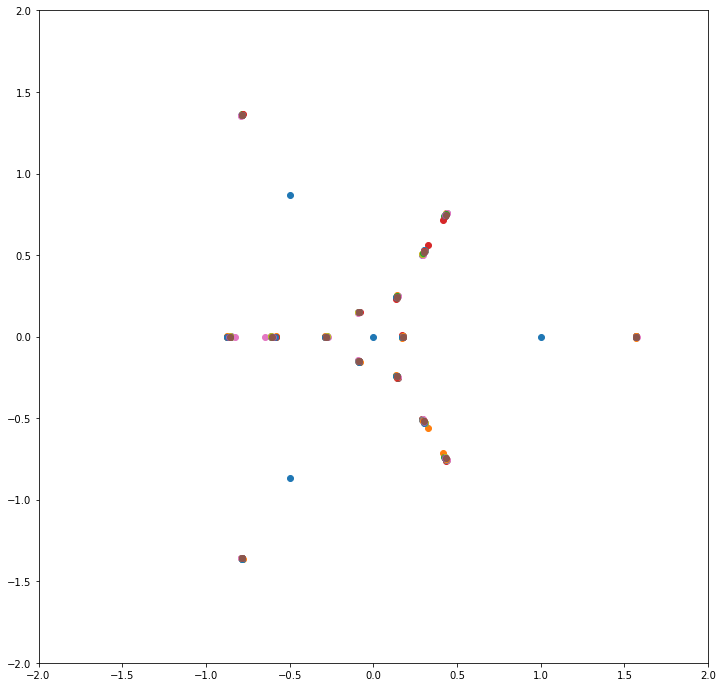

In [21]:

fig, ax = plt.subplots()
ax.scatter(xix,xiy)
for i in range(srcs):
    zzx = df_2RhieSolns[df_2RhieSolns['src']==i]['imagex'].values
    zzy = df_2RhieSolns[df_2RhieSolns['src']==i]['imagey'].values
    ax.scatter(zzx,zzy)
    
plt.axis([-2,2,-2,2])
fig.set_size_inches(12, 12)

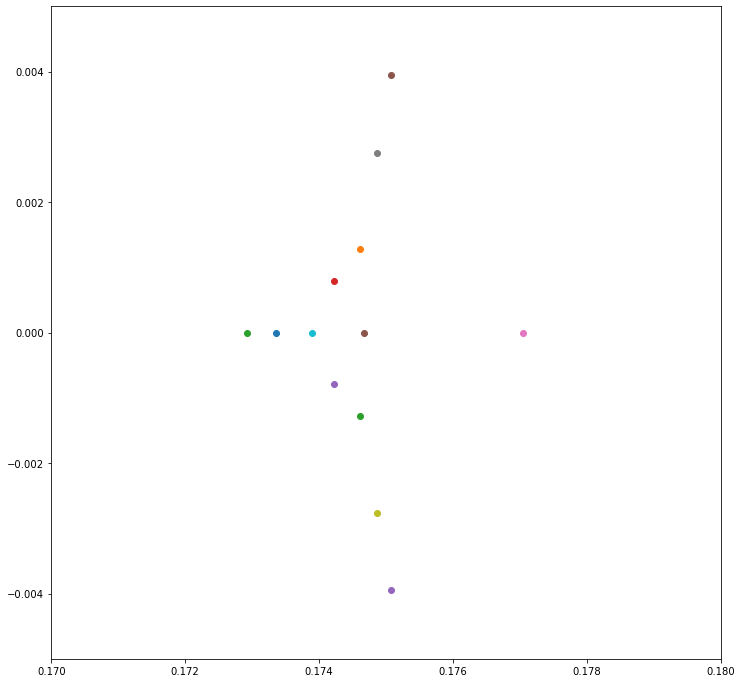

In [23]:

fig, ax = plt.subplots()
ax.scatter(xix,xiy)
for i in range(srcs):
    zzx = df_2RhieSolns[df_2RhieSolns['src']==i]['imagex'].values
    zzy = df_2RhieSolns[df_2RhieSolns['src']==i]['imagey'].values
    ax.scatter(zzx,zzy)
    
plt.axis([.17,.18,-.005,.005])
fig.set_size_inches(12, 12)

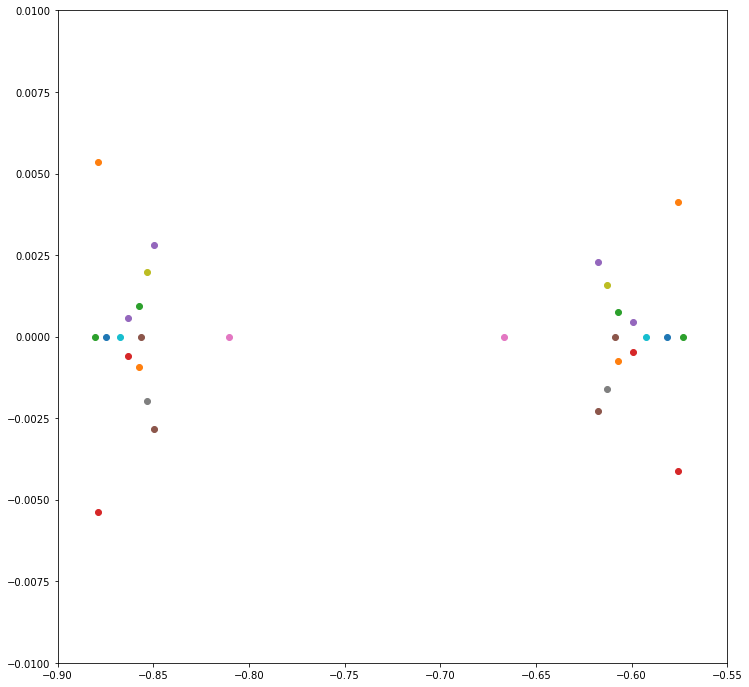

In [470]:

fig, ax = plt.subplots()
ax.scatter(xix,xiy)
for i in range(srcs):
    zzx = df_2RhieSolns[df_2RhieSolns['src']==i]['imagex'].values
    zzy = df_2RhieSolns[df_2RhieSolns['src']==i]['imagey'].values
    ax.scatter(zzx,zzy)
    
plt.axis([-.9,-.55,-.01,.01])
fig.set_size_inches(12, 12)

In [463]:
for i in range(srcs):
    t = df_2RhieSolns[df_2RhieSolns['src']==i]['imagex'].size
    print(t)

15
15
15
15
15
15
15
15
15
15
15
15
15
15
15


In [465]:
df_2RhieSolns[df_2RhieSolns['src']==i]


,g,src,image,imagex,imagey,xind,yind
210,3,14,"[-0.7859932713301724, 1.3594223356902806]",-0.785993,1.359422e+00,0,0
211,3,14,"[-0.8564066255454023, 2.847778708157205e-14]",-0.856407,2.847779e-14,0,1
212,3,14,"[-0.7859932711974782, -1.3594223357475654]",-0.785993,-1.359422e+00,0,14
213,3,14,"[0.43200414358455463, 0.7470876387409696]",0.432004,7.470876e-01,10,0
214,3,14,"[0.43200414358473316, -0.7470876387413581]",0.432004,-7.470876e-01,10,99
215,3,14,"[1.570868109549634, 3.511482832948322e-12]",1.570868,3.511483e-12,22,0
216,3,14,"[-0.6084544680582314, 7.248747456472494e-12]",-0.608454,7.248747e-12,22,3
217,3,14,"[-0.2796109524886892, -4.6315009187211266e-14]",-0.279611,-4.631501e-14,22,4
218,3,14,"[0.3000262937534453, -0.5187423626629929]",0.300026,-5.187424e-01,25,2
219,3,14,"[0.30002629375377277, 0.5187423626634986]",0.300026,5.187424e-01,25,97
